## Hard Drive Failure Prediction in the Data Center

### Data Analysis

In [1]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import os
import ast
import pickle
import re
from sklearn.preprocessing import StandardScaler

import dask
import dask.dataframe as dd
from dask import delayed
from dask.diagnostics import ProgressBar 

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.grid'] = True
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['grid.color'] = 'k'
# plt.rcParams['xtick.direction'] = 'in'
# plt.rcParams['ytick.direction'] = 'in'
# plt.rcParams['xtick.top'] = True
# plt.rcParams['ytick.right'] = True
# plt.rcParams['xtick.bottom'] = True
# plt.rcParams['ytick.left'] = True

#### Import for initial data exploration.

In [2]:
with open('columns_raw.txt', 'r') as f:
    cols_r = ast.literal_eval(f.read())

dtypes = {}
dtypes['date'] = 'object'
dtypes['serial_number'] = 'string'
dtypes['model'] = 'string'
dtypes['capacity_bytes'] = 'float' 
dtypes['failure'] = 'int'
dtypes.update({smart:'float' for smart in [c for c in cols_r if 'smart' in c]})

filelist = glob.glob(os.getcwd() + f'/data/p0_raw/1Q19/*.csv') 
ddf = dd.concat([dd.read_csv(f, dtype=dtypes) for f in filelist])
ddf = ddf.drop(columns=[c for c in ddf.columns if 'normalized' in c])
ddf.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_raw,smart_2_raw,smart_3_raw,smart_4_raw,smart_5_raw,...,smart_233_raw,smart_235_raw,smart_240_raw,smart_241_raw,smart_242_raw,smart_250_raw,smart_251_raw,smart_252_raw,smart_254_raw,smart_255_raw
0,2019-01-15,Z305B2QN,ST4000DM000,4.000787e+12,0,142108400.0,NaN,0.0,12.0,0.0,...,NaN,NaN,26798.0,4.581249e+10,1.200783e+11,NaN,NaN,NaN,NaN,NaN
1,2019-01-15,ZJV0XJQ4,ST12000NM0007,1.200014e+13,0,118572680.0,NaN,0.0,2.0,0.0,...,NaN,NaN,3334.0,2.994384e+10,3.706935e+10,NaN,NaN,NaN,NaN,NaN
2,2019-01-15,ZJV0XJQ3,ST12000NM0007,1.200014e+13,0,65643704.0,NaN,0.0,1.0,0.0,...,NaN,NaN,955.0,8.281419e+09,1.061619e+09,NaN,NaN,NaN,NaN,NaN
3,2019-01-15,ZJV0XJQ0,ST12000NM0007,1.200014e+13,0,230587104.0,NaN,0.0,6.0,0.0,...,NaN,NaN,4493.0,3.471373e+10,4.217710e+10,NaN,NaN,NaN,NaN,NaN
4,2019-01-15,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4.000787e+12,0,0.0,103.0,436.0,9.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* What hard drive models are the most prevalent in the Backblaze dataset?
* What portion of each hard drive model recorded a failure?

In [3]:
m_stats = ddf[['serial_number', 'model']].drop_duplicates().groupby('model').count().compute()
m_stats.columns = ['count']
m_stats['percent_total'] = m_stats / m_stats.sum() * 100
m_stats = m_stats.sort_values('percent_total')

failures = ddf[['serial_number', 'model', 'failure']].drop_duplicates().groupby(['model', 'serial_number']).sum().compute()
m_stats = pd.merge(m_stats, failures.reset_index().groupby(['model', ]).sum(), left_index=True, right_index=True).rename(columns={'failure':'failures'})
m_stats['percent_failure_by_model'] = m_stats['failures'] / m_stats['count'] * 100

days = ddf[['serial_number', 'model', 'smart_9_raw']].groupby(['serial_number', 'model',] ).max().reset_index().compute()
days = days.replace(0, np.nan).dropna()
days['smart_9_raw'] = days['smart_9_raw'] / 24
days_active = days[['model', 'smart_9_raw']].groupby('model', )['smart_9_raw'].apply(list).to_dict()

m_stats = pd.merge(m_stats, days.groupby('model').mean(), left_index=True, right_index=True).rename(columns={'smart_9_raw':'days_active'})
m_stats.head()

,count,percent_total,failures,percent_failure_by_model,days_active
model,,,,,
Hitachi HDS724040ALE640,1,0.000868,0,0.0,1482.583333
WDC WD3200BEKX,1,0.000868,0,0.0,1660.541667
HGST HMS5C4040BLE641,1,0.000868,0,0.0,151.833333
WDC WD3200AAJS,1,0.000868,0,0.0,2025.166667
WDC WD2500AAJS,1,0.000868,0,0.0,2093.291667


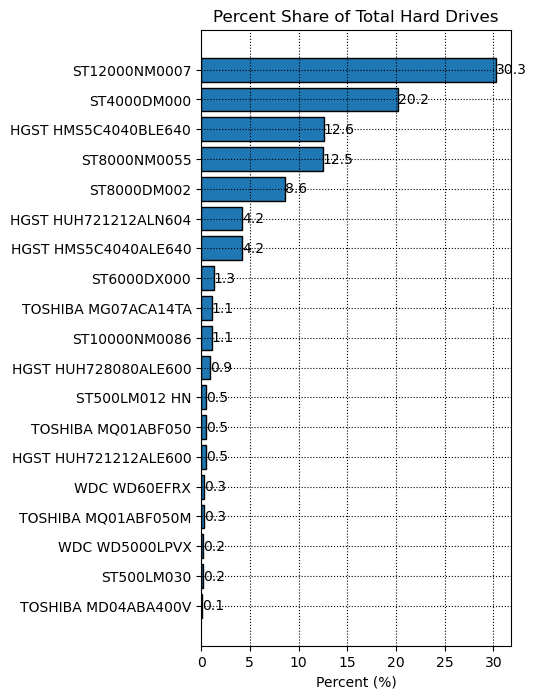

In [4]:
fig, ax = plt.subplots(figsize=(4, 8))

p = m_stats.loc[m_stats['percent_total'] > 0.1]

b = ax.barh(p.index, p['percent_total'].round(1), edgecolor='k')
ax.bar_label(b, label_type='edge')
#ax.tick_params(axis='x', rotation=85)
ax.set_xlabel('Percent (%)')
#ax.set_xlim(0, 35)
ax.set_title('Percent Share of Total Hard Drives', size=12)
plt.show()

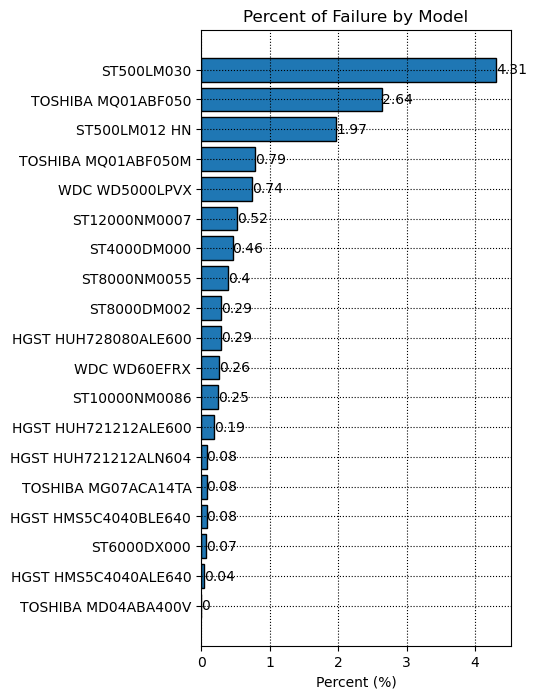

In [5]:
fig, ax = plt.subplots(figsize=(4, 8))
p = m_stats.loc[m_stats['percent_total'] > 0.1].sort_values('percent_failure_by_model')
b = ax.barh(p.index, p['percent_failure_by_model'].round(2), edgecolor='k')
ax.bar_label(b, label_type='edge')
#ax.set_xlim(0, 6)
#ax.tick_params(axis='x', rotation=85)
ax.set_xlabel('Percent (%)')
ax.set_title('Percent of Failure by Model', size=12)
plt.show()

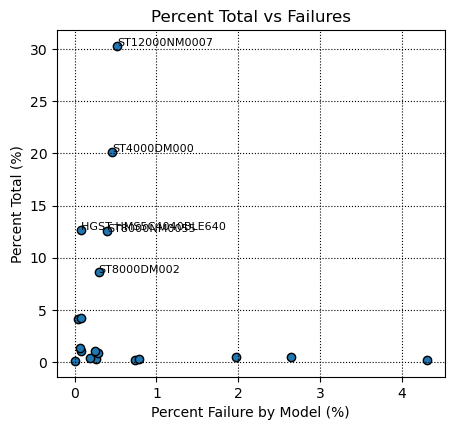

In [6]:
fig, ax = plt.subplots(figsize=(5, 4.5))
p = m_stats.loc[m_stats['percent_total'] > 0.1]
ax.scatter(p['percent_failure_by_model'], p['percent_total'], edgecolor='k')
labels = p.reset_index()
labels['labels'] = np.where(labels['percent_total'] > 8, labels['model'], '')

for i, txt in enumerate(labels['labels']):
    ax.annotate(txt, (p['percent_failure_by_model'][i], p['percent_total'][i]), size=8)

#ax.tick_params(axis='x', rotation=85)
     
ax.set_xlabel('Percent Failure by Model (%)')
ax.set_ylabel('Percent Total (%)')
#ax.set_xlim(-1, 5)
# ax.set_ylim(-1, 35)
ax.set_title('Percent Total vs Failures', size=12)
plt.show()


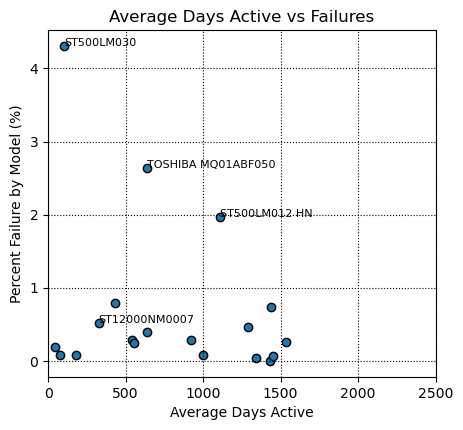

In [7]:
fig, ax = plt.subplots(figsize=(5, 4.5))
p = m_stats.loc[m_stats['percent_total'] > 0.1]
ax.scatter(p['days_active'], p['percent_failure_by_model'], edgecolor='k')
labels = p.reset_index()
labels['labels'] = np.where((labels['percent_failure_by_model'] > 1 )| (labels['model'] == 'ST12000NM0007'), labels['model'], '')

for i, txt in enumerate(labels['labels']):
    ax.annotate(txt, (p['days_active'][i], p['percent_failure_by_model'][i]), size=8)
     
ax.set_ylabel('Percent Failure by Model (%)')
ax.set_xlabel('Average Days Active')
ax.set_xlim(0, 2500)
#ax.set_ylim(,14)
ax.set_title('Average Days Active vs Failures', size=12)
plt.show()

* The Seagate ST12000NM0007 model is the most prevalent in the data center.


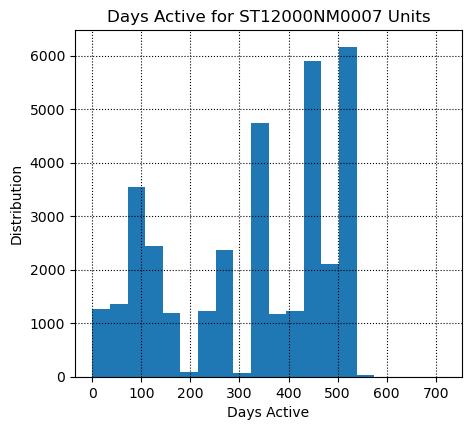

In [8]:
fig, ax = plt.subplots(figsize=(5, 4.5))
ax.hist(days_active['ST12000NM0007'], bins=20)
ax.set_ylabel('Distribution')
ax.set_xlabel('Days Active')
ax.set_title('Days Active for ST12000NM0007 Units', size=12)
plt.show()

#### Analysis of ST12000NM0007 Model

In [9]:
filelist = glob.glob(os.getcwd() + f'/data/p0_raw/*/*.csv')
ddf = dd.concat([dd.read_csv(f, dtype=dtypes) for f in filelist])
ddf = ddf.drop(columns=[c for c in ddf.columns if 'normalized' in c])
ddf = ddf.loc[ddf['model'] == 'ST12000NM0007']

ddf.head()

/home/trent/miniconda3/envs/hrddrv/lib/python3.10/site-packages/dask/dataframe/core.py:7506: UserWarning: Insufficient elements for `head`. 5 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


,date,serial_number,model,capacity_bytes,failure,smart_1_raw,smart_2_raw,smart_3_raw,smart_4_raw,smart_5_raw,...,smart_166_raw,smart_167_raw,smart_169_raw,smart_176_raw,smart_178_raw,smart_171_raw,smart_172_raw,smart_230_raw,smart_244_raw,smart_246_raw


In [10]:
missing_values = ddf.isnull().sum()
missing_values = ((missing_values / ddf.index.size) * 100)
with ProgressBar():
    missing_values = missing_values.compute()
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(missing_values)

[########################################] | 100% Completed | 34m 43s
date                0.00000
serial_number       0.00000
model               0.00000
capacity_bytes      0.00000
failure             0.00000
smart_1_raw         0.01399
smart_2_raw       100.00000
smart_3_raw         0.01399
smart_4_raw         0.01399
smart_5_raw         0.01399
smart_7_raw         0.01399
smart_8_raw       100.00000
smart_9_raw         0.01399
smart_10_raw        0.01399
smart_11_raw      100.00000
smart_12_raw        0.01399
smart_13_raw      100.00000
smart_15_raw      100.00000
smart_22_raw      100.00000
smart_183_raw     100.00000
smart_184_raw     100.00000
smart_187_raw       0.01399
smart_188_raw       0.01399
smart_189_raw     100.00000
smart_190_raw       0.01399
smart_191_raw     100.00000
smart_192_raw       0.01399
smart_193_raw       0.01399
smart_194_raw       0.01399
smart_195_raw       0.01399
smart_196_raw     100.00000
smart_197_raw       0.01399
smart_198_raw       0.01399
smart_

In [11]:
ddf = ddf.drop(columns=missing_values[missing_values > 10].index)
ddf.head()

/home/trent/miniconda3/envs/hrddrv/lib/python3.10/site-packages/dask/dataframe/core.py:7506: UserWarning: Insufficient elements for `head`. 5 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


,date,serial_number,model,capacity_bytes,failure,smart_1_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,...,smart_193_raw,smart_194_raw,smart_195_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_200_raw,smart_240_raw,smart_241_raw,smart_242_raw


In [12]:
l = ddf.loc[ddf['failure'] == 1]['serial_number'].unique().compute()
df_fails = ddf.loc[ddf['serial_number'].isin(l)].compute()

df_fails.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,...,smart_193_raw,smart_194_raw,smart_195_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_200_raw,smart_240_raw,smart_241_raw,smart_242_raw
89,2021-03-29,ZJV46YE5,ST12000NM0007,1.200014e+13,0,170123896.0,0.0,16.0,0.0,993280433.0,...,935.0,31.0,170123896.0,0.0,0.0,0.0,0.0,13221.0,6.750886e+10,1.943803e+11
1840,2021-03-29,ZJV3XZFF,ST12000NM0007,1.200014e+13,0,137965328.0,0.0,14.0,0.0,22841999.0,...,881.0,26.0,137965328.0,0.0,0.0,0.0,0.0,13188.0,6.752214e+10,2.058095e+11
1889,2021-03-29,ZCH0APGY,ST12000NM0007,1.200014e+13,0,104864728.0,0.0,3.0,49648.0,530368890.0,...,1316.0,25.0,104864728.0,0.0,0.0,0.0,0.0,25122.0,5.962564e+10,2.556650e+11
2401,2021-03-29,ZJV3BE6Z,ST12000NM0007,1.200014e+13,0,213169472.0,0.0,5.0,34608.0,122124030.0,...,890.0,28.0,213169472.0,16.0,16.0,0.0,0.0,13221.0,6.750814e+10,2.144437e+11
3149,2021-03-29,ZJV0F4FY,ST12000NM0007,1.200014e+13,0,221217904.0,0.0,12.0,0.0,491365387.0,...,1666.0,30.0,221217904.0,0.0,0.0,0.0,0.0,25000.0,5.532903e+10,2.434764e+11


In [13]:
feature_cols = [c for c in df_fails.columns if 'smart' in c] 

# scale
ss = StandardScaler()
df_fails[feature_cols] = ss.fit_transform(df_fails[feature_cols].values)

d = df_fails.drop(columns=['date', 'serial_number', 'model', 'capacity_bytes', ]).melt(id_vars=['failure'], var_name='Feature', value_name='Distribution')

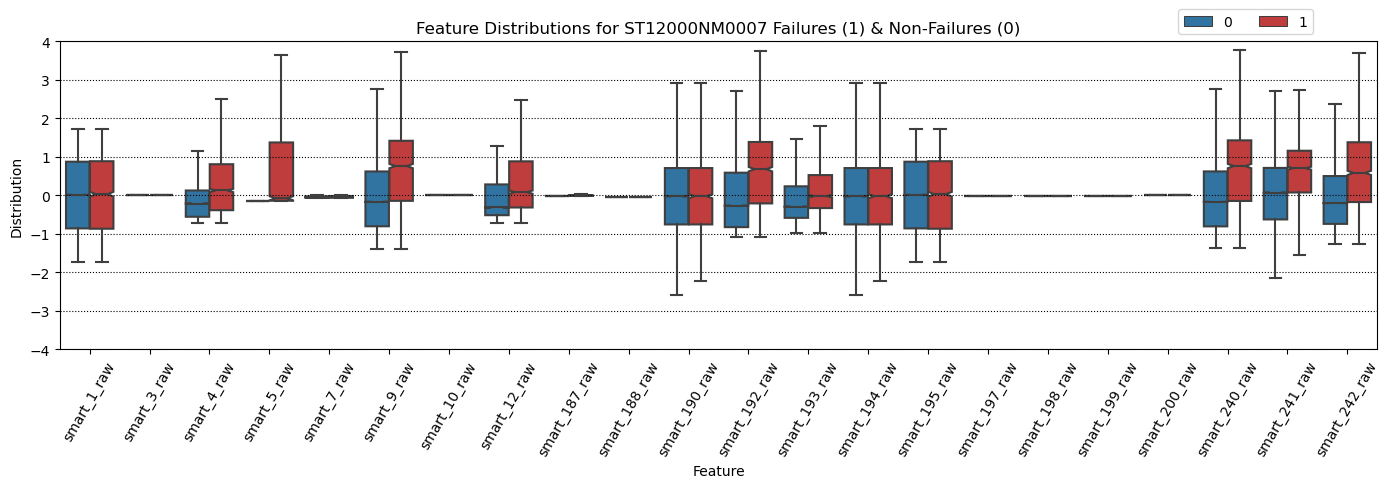

In [14]:
plt.figure(figsize=(17, 4))

ax = sns.boxplot(
            data=d,
            x="Feature", 
            y="Distribution",
            hue="failure", 
            palette=["tab:blue", "tab:red"],
            notch=True, 
            showfliers=False,
            # flierprops={"marker": "."},
           )
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.9, 1), ncol=2, title=None)
ax.set_ylim(-4, 4)
plt.xticks(rotation=60)
plt.title('Feature Distributions for ST12000NM0007 Failures (1) & Non-Failures (0)')
plt.show()

In [15]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(ddf[feature_cols].describe().compute())

        smart_1_raw  smart_3_raw   smart_4_raw   smart_5_raw   smart_7_raw  \
count  3.579144e+07   35791440.0  3.579144e+07  3.579144e+07  3.579144e+07   
mean   1.225418e+08          0.0  6.655813e+00  7.078017e+01  9.090806e+08   
std    7.038256e+07          0.0  9.171833e+00  1.337260e+03  1.738055e+10   
min    0.000000e+00          0.0  1.000000e+00  0.000000e+00  6.800000e+01   
25%    1.047745e+08          0.0  4.000000e+00  0.000000e+00  3.077743e+08   
50%    1.466230e+08          0.0  7.000000e+00  0.000000e+00  5.699260e+08   
75%    2.044271e+08          0.0  1.900000e+01  0.000000e+00  9.274273e+08   
max    2.441406e+08          0.0  8.030000e+02  6.552800e+04  3.411065e+12   

        smart_9_raw  smart_10_raw  smart_12_raw  smart_187_raw  smart_188_raw  \
count  3.579144e+07    35791440.0  3.579144e+07   3.579144e+07   3.579144e+07   
mean   1.213043e+04           0.0  6.027854e+00   1.469601e+00   1.902020e+08   
std    7.506845e+03           0.0  7.510942e+00   1.94

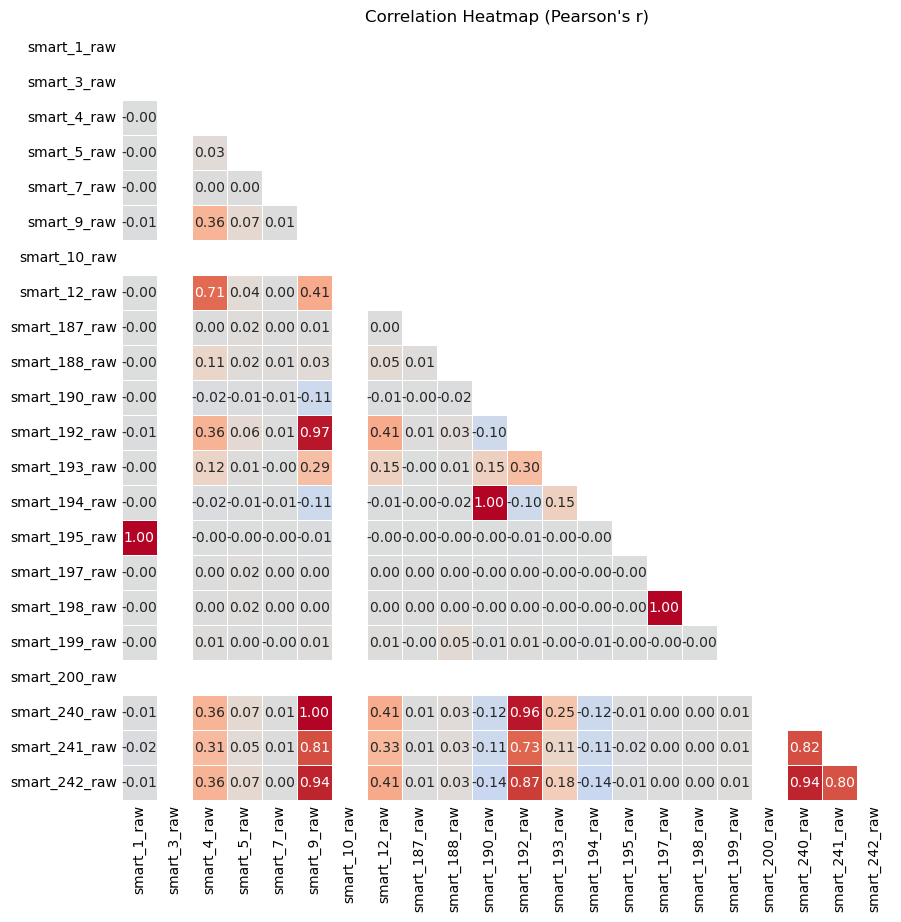

In [16]:

df_temp = ddf.loc[:, feature_cols].sample(frac=0.10, random_state=0).compute()
ss = StandardScaler()
ss = ss.fit(df_temp[feature_cols].values)
df_temp[feature_cols] = ss.transform(df_temp[feature_cols].values)

corr = df_temp.corr()
np.zeros_like(corr)
mask = np.triu(corr)

plt.figure(figsize=(10, 10))
sns.heatmap(data=corr, cmap='coolwarm', vmin=-1.0, vmax=1.0, linewidths=0.6, mask=mask, square=True, annot=True, fmt='0.2f' ,cbar=False)
plt.tick_params(length=0)
plt.title('Correlation Heatmap (Pearson\'s r)', size=12)
plt.show()

* ['smart_194_raw', 'smart_195_raw', 'smart_198_raw', 'smart_240_raw'] appear to be redundant, i.e., 100% correlated with other columns.